ORGANIZAR LA INFORMACION

In [1]:
import pandas as pd
import os
import shutil

In [2]:
# poner todas las imágenes en una carpeta y especificar la ruta:
data_dir = os.getcwd() + "/data/all_images/"

In [3]:
# Path del directorio destino dnde se quieren las subcarpetas
dest_dir = os.getcwd() + "/data/reorganized/"

skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')

In [4]:

#Lee el csv con las imgenes y labels
skin_df2 = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')
print(skin_df['dx'].value_counts())

label=skin_df2['dx'].unique().tolist()  #convertir los labels en una lista
label_images = []

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [7]:
#copia las imagenes en la nueva subcarpeta
for i in label:
    os.mkdir(dest_dir + str(i) + "/")
    sample = skin_df2[skin_df2['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]

In [8]:

# crear  data generator para manejar los datos  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

#definir datagen. 
datagen = ImageDataGenerator()

In [9]:

#Definir directorio de entrenamiento que contiene las subcarpetas
train_dir = os.getcwd() + "/data/reorganized/"
#USe flow_from_directory
train_data_keras = datagen.flow_from_directory(directory=train_dir,
                                         class_mode='categorical',
                                         batch_size=16,  #16 images at a time
                                         target_size=(32,32))  #Resize images

Found 10015 images belonging to 7 classes.


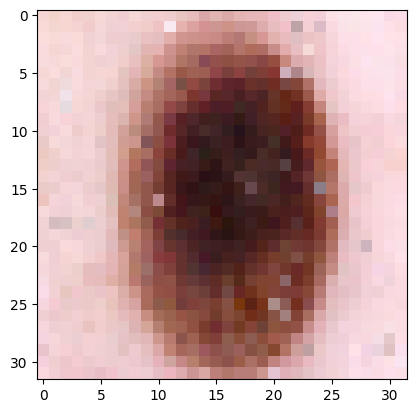

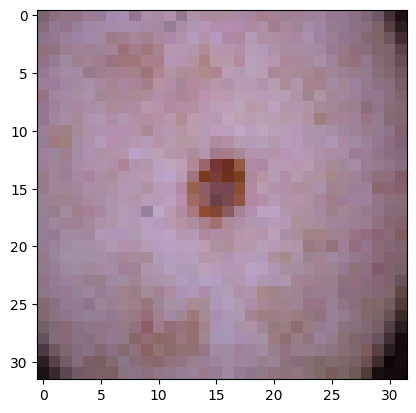

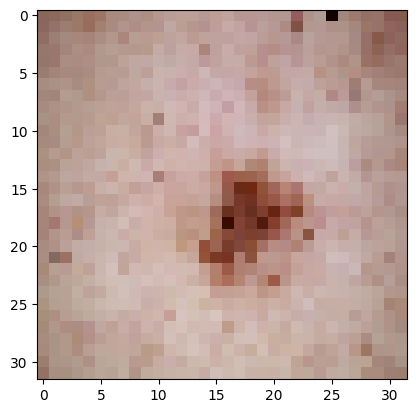

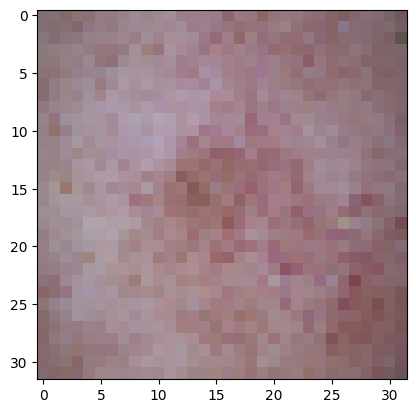

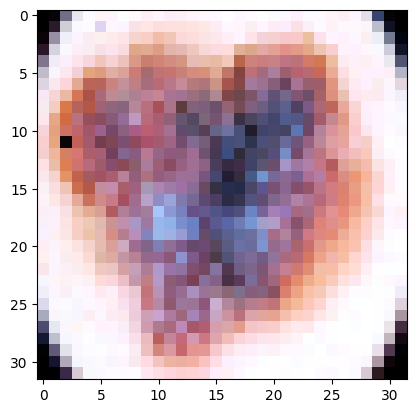

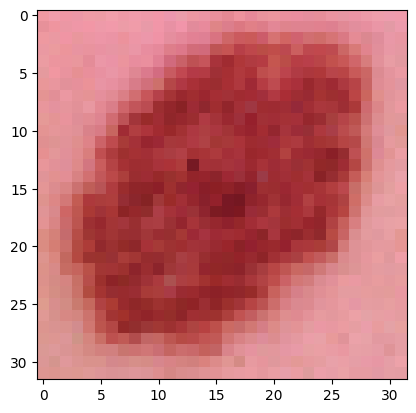

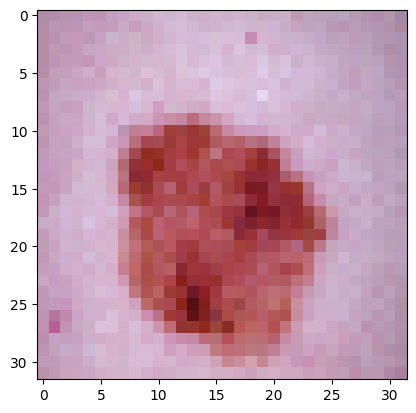

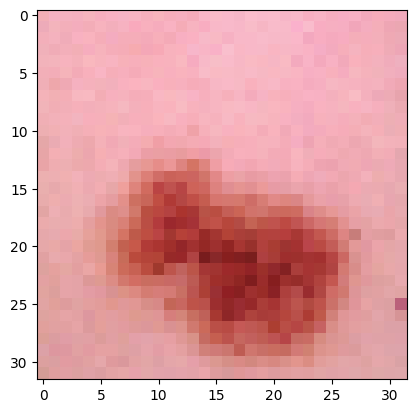

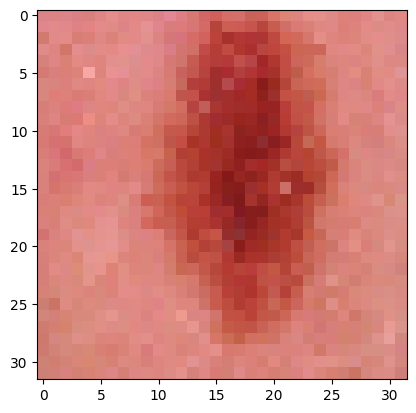

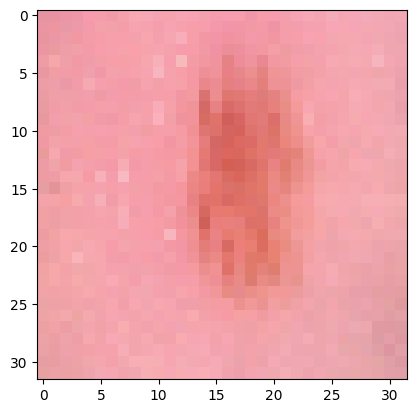

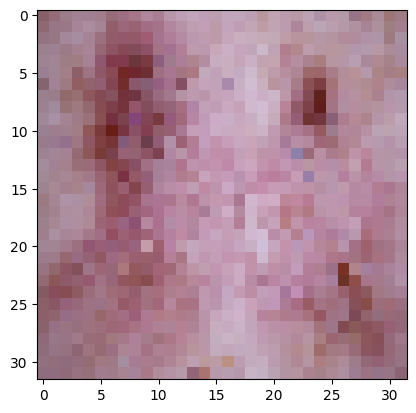

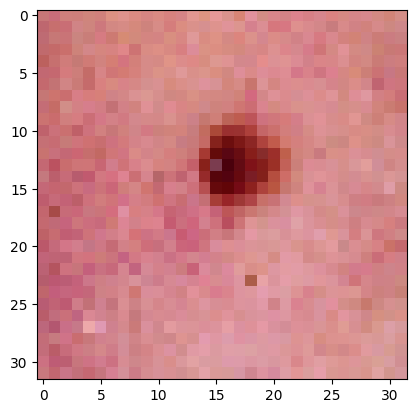

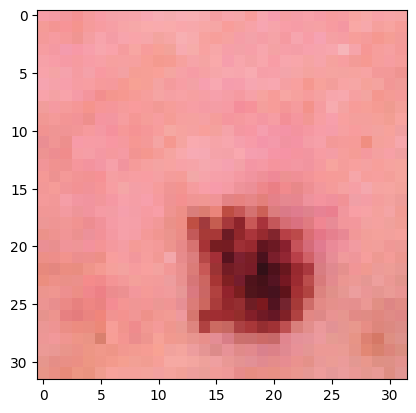

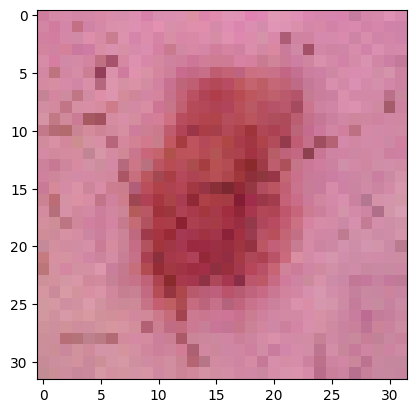

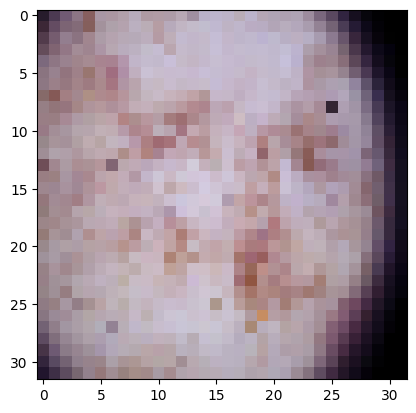

In [10]:
#verificar las imagenes para un batch
x, y = next(train_data_keras)
#ver cada imagen
for i in range (0,15):
    image = x[i].astype(int)
    plt.imshow(image)
    plt.show()

ENTRENAMIENTO DEL MODELO

In [11]:
import numpy as np
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from keras.models import Sequential

In [12]:
SIZE=32

In [13]:
# label encoding ta valores numericos a partir de texto
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [14]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization        dataset  label  
1617             face   vidir_modern      4  
8128  lower extremity    vienna_dias      5  
2168             back      rosendahl      4  
1090            trunk  vidir_molemax      2  
7754          abdomen   vidir_modern      5  
8071    

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9928\1260793626.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


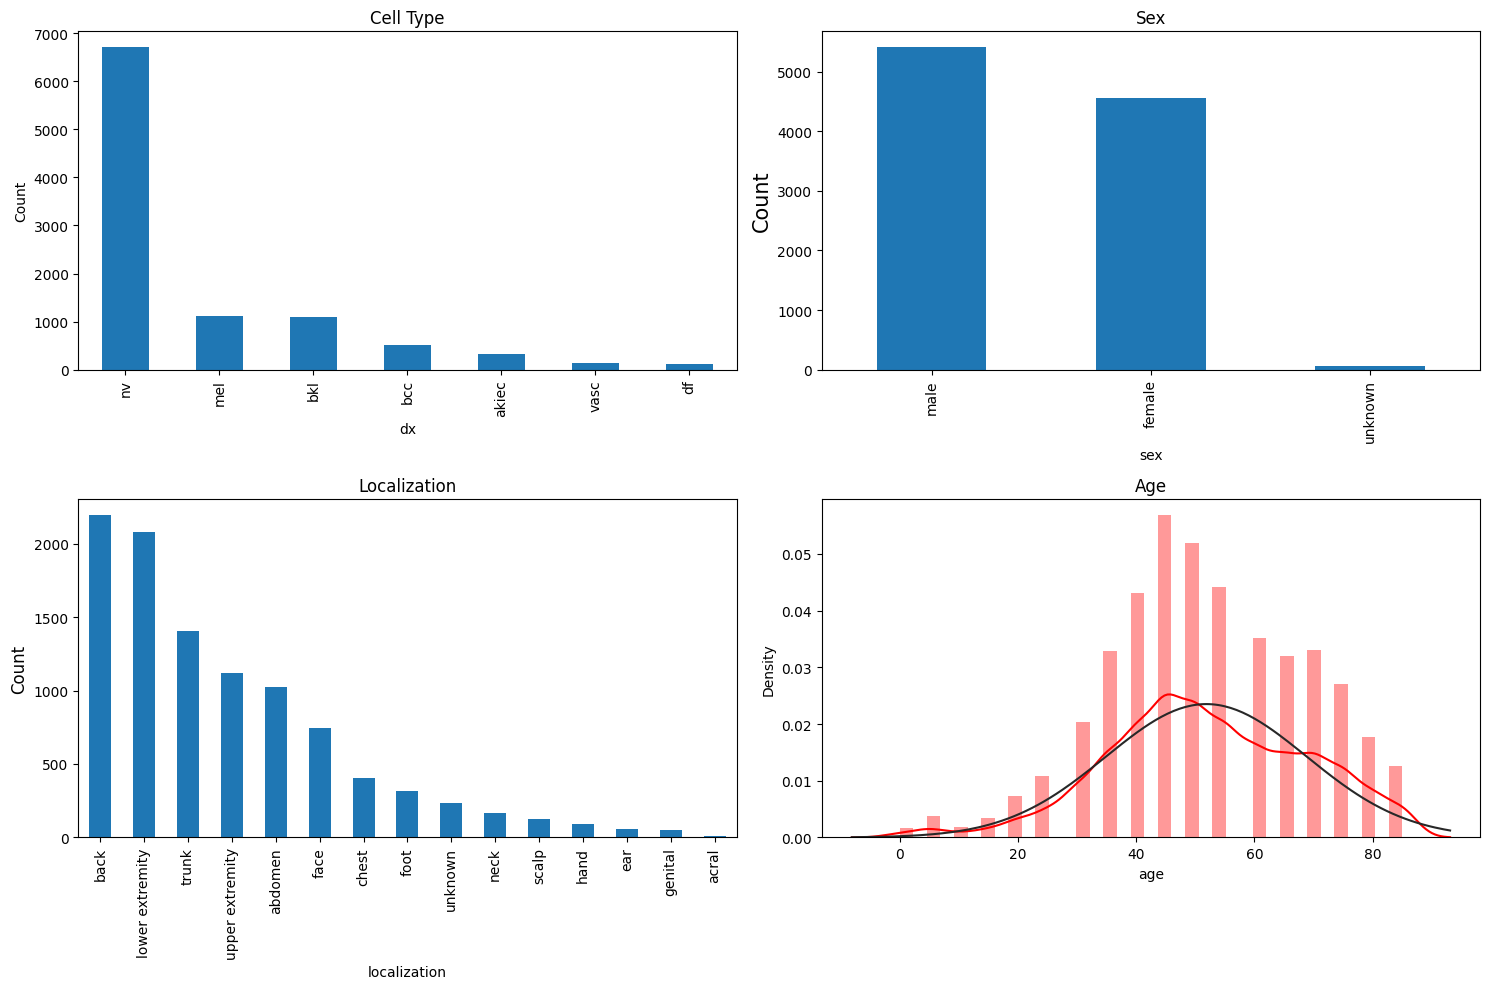

In [15]:
# visualizacion de la distribucion de los datos
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [16]:
# Distribucion de los datos en varias clases 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#balancear datos
#separar cada clase, resample y combinarlo en un solo dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [17]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [18]:
print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [19]:
#ahora se leen las imagenes basadas en el ID desde el archivo csv



image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}

#Definir el path y agregarlo como una nueva columna
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#usar el path para leer las imagenes
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


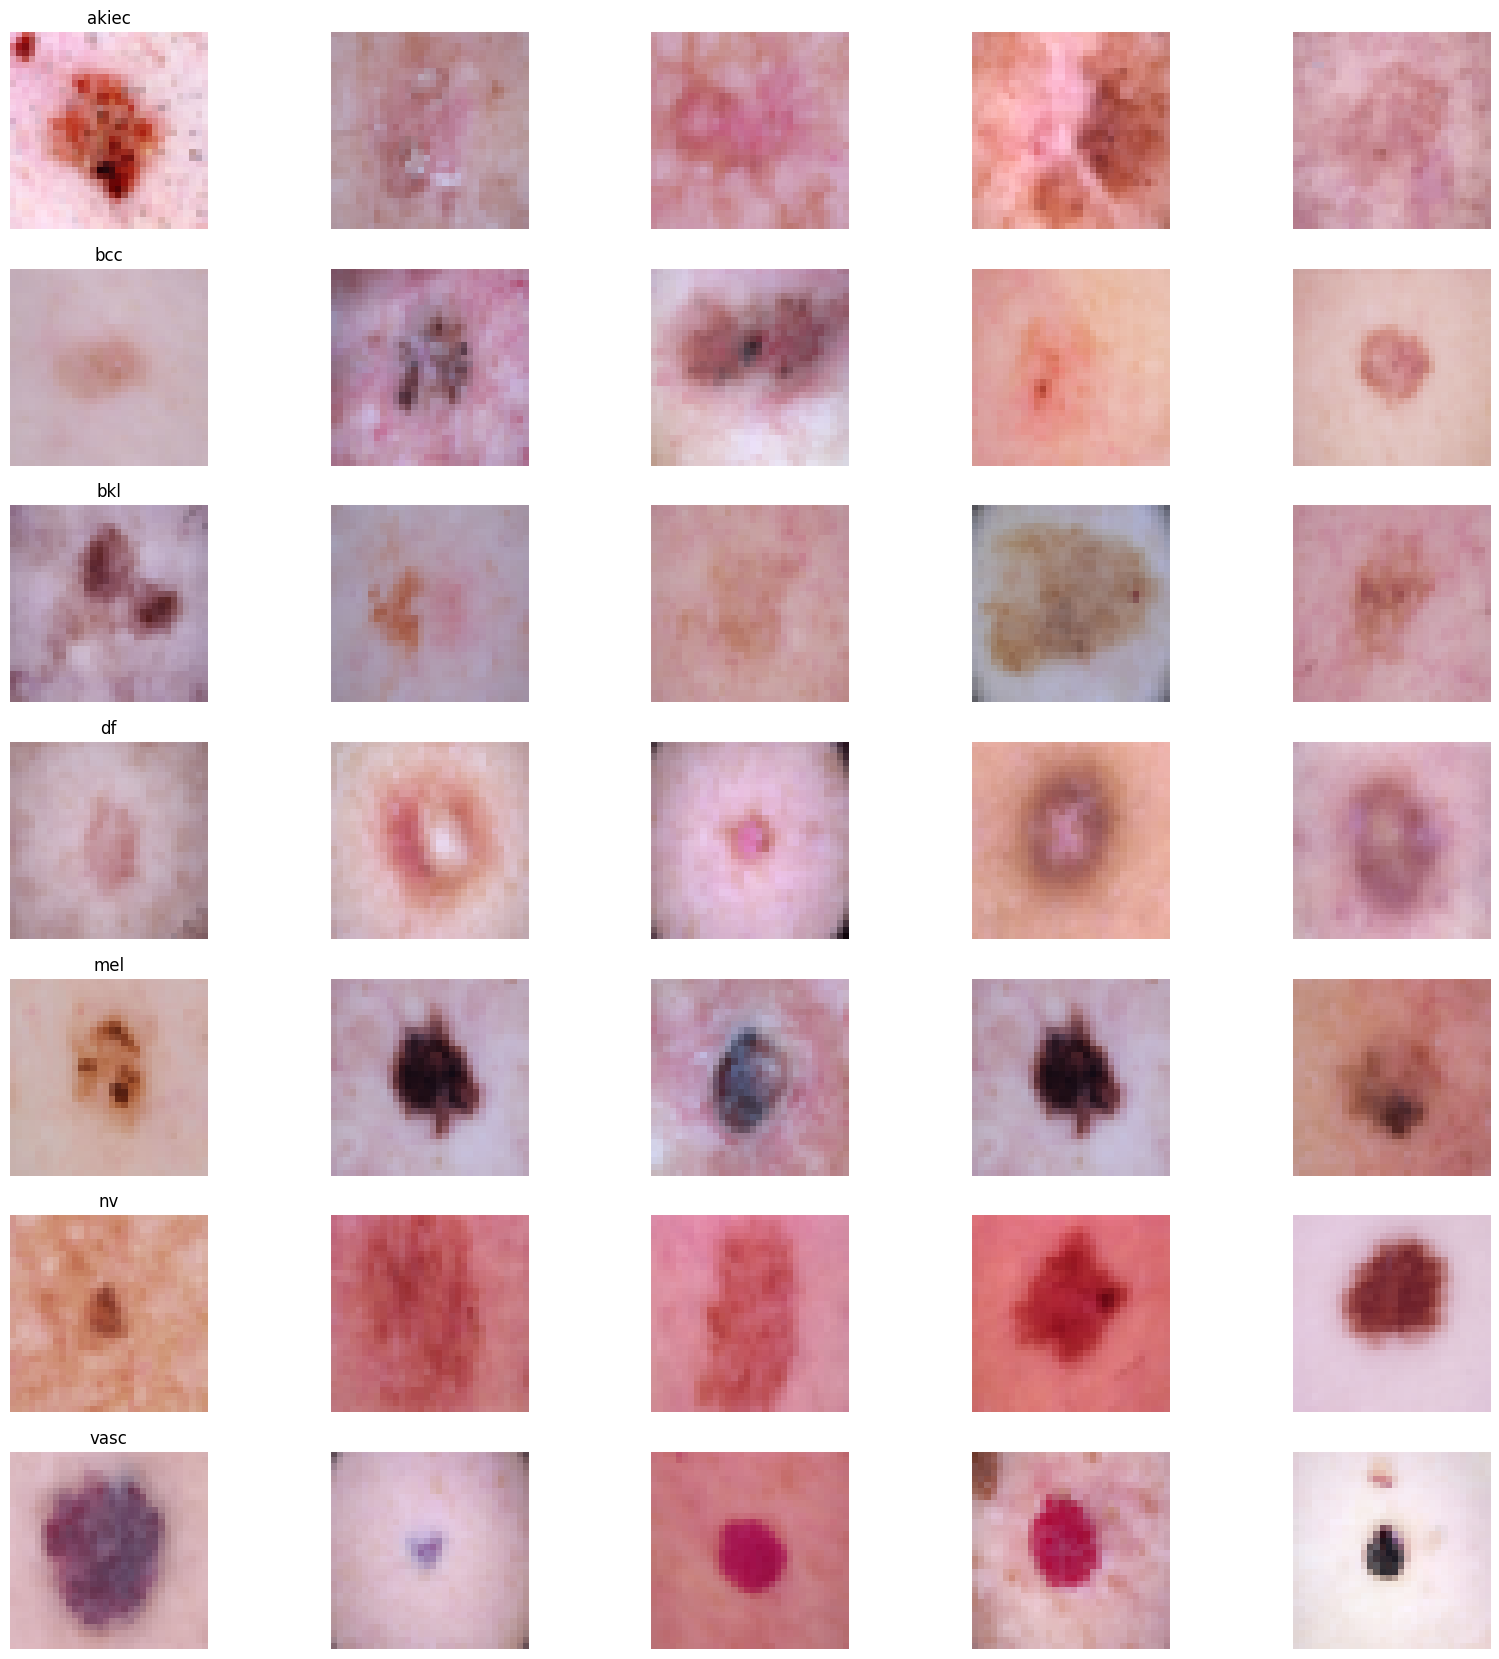

In [20]:
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [21]:
#convertir la coplumna de imagenes por un arrgelo de numpy
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # normalizar los datos
Y=skin_df_balanced['label']  #asignar la clase a la variable Y
Y_cat = to_categorical(Y, num_classes=7) #convertir a categorico
#dividir en conjutno de train y test
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [22]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3,3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["acc"])

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Train


batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


Epoch 1/50
165/165 - 61s - 371ms/step - acc: 0.1909 - loss: 1.8965 - val_acc: 0.2674 - val_loss: 1.8150
Epoch 2/50
165/165 - 80s - 487ms/step - acc: 0.2678 - loss: 1.7656 - val_acc: 0.2686 - val_loss: 1.7328
Epoch 3/50
165/165 - 82s - 498ms/step - acc: 0.2895 - loss: 1.7024 - val_acc: 0.2937 - val_loss: 1.7008
Epoch 4/50
165/165 - 83s - 500ms/step - acc: 0.3615 - loss: 1.5899 - val_acc: 0.3566 - val_loss: 1.5282
Epoch 5/50
165/165 - 81s - 494ms/step - acc: 0.4088 - loss: 1.4681 - val_acc: 0.3954 - val_loss: 1.4553
Epoch 6/50
165/165 - 82s - 498ms/step - acc: 0.4179 - loss: 1.4438 - val_acc: 0.3657 - val_loss: 1.4870
Epoch 7/50
165/165 - 82s - 497ms/step - acc: 0.4457 - loss: 1.4004 - val_acc: 0.4446 - val_loss: 1.4006
Epoch 8/50
165/165 - 82s - 498ms/step - acc: 0.4716 - loss: 1.3272 - val_acc: 0.4137 - val_loss: 1.3990
Epoch 9/50
165/165 - 82s - 500ms/step - acc: 0.4781 - loss: 1.3238 - val_acc: 0.4823 - val_loss: 1.3201
Epoch 10/50
165/165 - 82s - 495ms/step - acc: 0.4754 - loss: 1.3

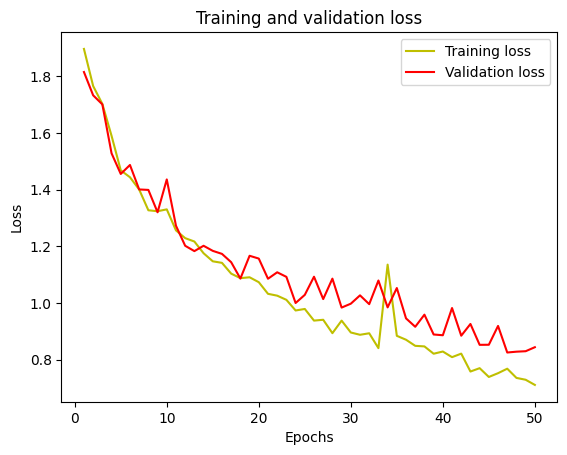

In [48]:
h#plot el acuracy y loss de training y validation para cada epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


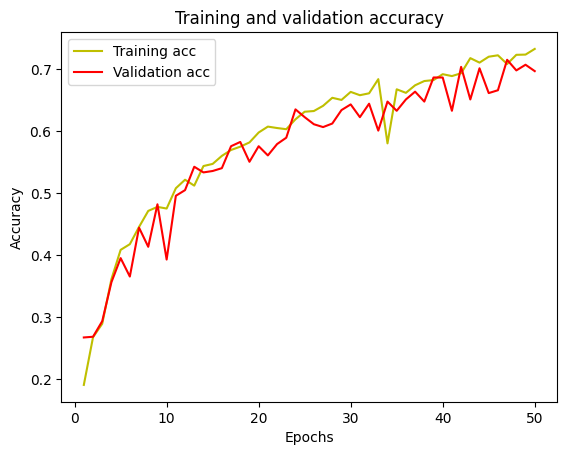

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix

# prediccion de los datos de test
y_pred = model.predict(x_test)
# convertir las clases en vectores one hot
y_pred_classes = np.argmax(y_pred, axis = 1) 
#convertir los datos de test en vectores one hot
y_true = np.argmax(y_test, axis = 1) 

#imprimir la matriz de confusion
cm = confusion_matrix(y_true, y_pred_classes)




28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step


<Axes: >

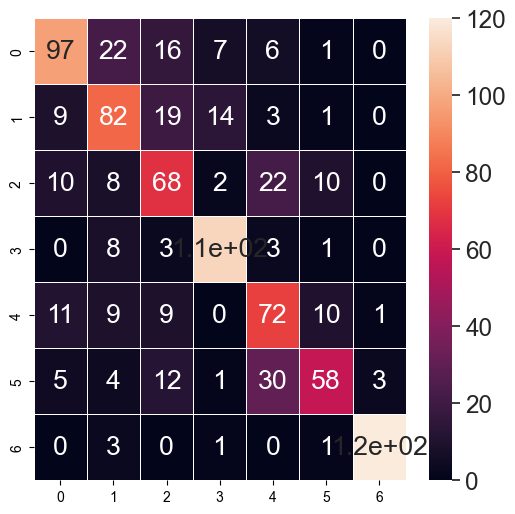

In [52]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

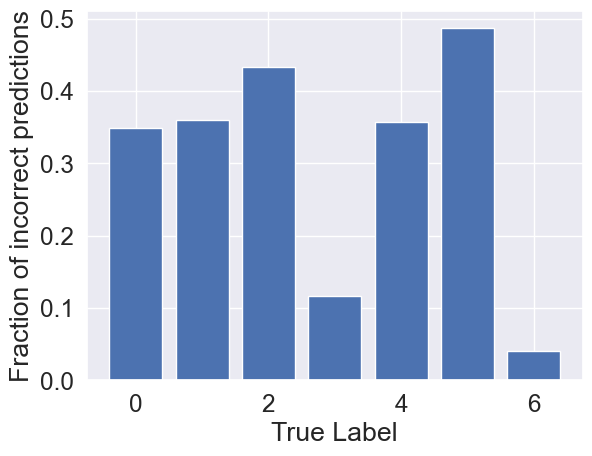

In [53]:
#Imprimir las fracciones de clasificacion incorrectas
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')